In [1]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
stance = pd.read_csv("//Users//kelvin//Downloads//clean.csv", header=0,)
stance.head(10)

,Unnamed: 0,Headline,unrelated,agree,disagree,discuss,Body,Number.Of.Common.Words,Number.Of.Words.In.Body,Number.Of.Words.In.Headline,Stance
0,1,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...,2,198,17,unrelated
1,2,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...,10,429,11,agree
2,3,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...,4,187,17,unrelated
3,4,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...,2,79,14,unrelated
4,5,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...,9,627,11,disagree
5,6,nasa confirms earth will experience days of to...,0,1,0,0,thousands of people have been duped by a fake ...,16,425,16,agree
6,7,accused boston marathon bomber severely injure...,1,0,0,0,a british fighter who travelled to iraq to sto...,2,961,14,unrelated
7,8,identity of isis terrorist known as jihadi joh...,1,0,0,0,adding to apple s ios launch troubles a report...,2,315,10,unrelated
8,9,banksy arrested real identity revealed is the ...,0,1,0,0,if you ve seen a story floating around on your...,8,347,12,agree
9,10,british aid worker confirmed murdered by isis,1,0,0,0,the british islamic state militant who has fea...,4,238,7,unrelated


In [2]:
stance.drop('Unnamed: 0' , axis=1, inplace=True)
# convert label to a numerical variable
stance['label_num'] = stance.Stance.map({'agree':0, 'disagree':1, 'discuss':2, 'unrelated':3})

In [5]:
X = stance.Body
Y = stance.label_num

In [6]:
def import_data():
    from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 42, stratify=Y)

    print("loading training data")
    trainX = X_train
    trainY = Y_train
    print("loading test data")
    testX = X_test
    testY = Y_test
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()

loading training data
loading test data


In [8]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(trainX)
X_train_dtm = vect.transform(trainX)
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(trainX)
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(testX)

In [14]:
X_train_dtm.shape

(44974, 22330)

In [19]:
# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = X_train_dtm.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[0]

# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,global_step= 1,decay_steps=trainX.shape[0],decay_rate= 0.95,staircase=True)

In [20]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [21]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [23]:
# INITIALIZE our weights and biases
init_OP = tf.global_variables_initializer()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [24]:
# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")
# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

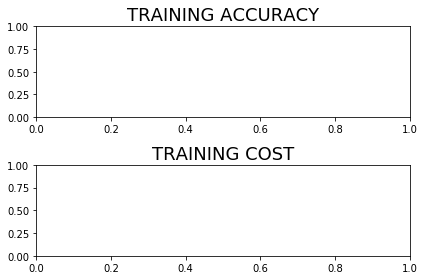

In [25]:
epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

In [ ]:
# Create a tensorflow session
sess = tf.Session()
# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: X_train_dtm, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: X_train_dtm, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)




In [ ]:
# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: X_test_dtm, 
                                                                yGold: testY})))